In [1]:
dataset = 'cassins'
algorithm = 'ivis'
n_components = 2
dims = (32,32,1)


In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### load packages

In [5]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')



top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)

syllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

syllable_df[:3]
syllable_df = syllable_df.reset_index()

syllable_df['subset'] = 'train'
syllable_df.loc[:1000, 'subset'] = 'valid'
syllable_df.loc[1000:1999, 'subset'] = 'test'

specs = np.array(list(syllable_df.spectrogram.values))
specs = np.array([np.concatenate([np.zeros((32,1)), i], axis=1) for i in tqdm(specs)])


syllable_df['spectrogram'] = syllable_df['spectrogram'].astype('object')
syllable_df['spectrogram'] = list(specs)


Y_train = np.array(list(syllable_df.labels.values[syllable_df.subset == 'train']))
Y_valid = np.array(list(syllable_df.labels.values[syllable_df.subset == 'valid']))
Y_test = np.array(list(syllable_df.labels.values[syllable_df.subset == 'test']))

X_train = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'test'])) #/ 255.

X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).astype('int').flatten()
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

  0%|          | 0/26984 [00:00<?, ?it/s]

### Create model and train

In [8]:
from ivis import Ivis
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

In [9]:
from tensorflow.keras.layers import (
    Conv2D,
    Reshape,
    Bidirectional,
    Dense,
    RepeatVector,
    TimeDistributed,
    LSTM
)
n_components=2

In [10]:
def create_model():
    """model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

    model.add(tf.keras.layers.Flatten())
    """
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    ),
    Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    ),
    Reshape(target_shape=(8, 2*128)),
    Bidirectional(LSTM(units=100, activation="relu")),
    Dense(units=512),
    #Dense(units=n_components),
    ])
    return model

In [11]:
base_model = create_model()

In [12]:
X_train.shape

(24984, 32, 32)

In [13]:
x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X_train_flat).reshape([len(X_train)] + list(dims))

In [14]:
# Set ivis parameters
model = Ivis(model=base_model, embedding_dims=2)

In [15]:
# Generate embeddings
embeddings =z = model.fit_transform(X_scaled)

  2%|▏         | 500/24984 [00:00<00:04, 4995.97it/s]

Building KNN index
Flattening multidimensional input before building KNN index using Annoy


100%|██████████| 24984/24984 [00:04<00:00, 5477.42it/s]


Extracting KNN neighbours
Flattening data before retrieving KNN from index


100%|██████████| 24984/24984 [00:04<00:00, 5102.79it/s]


Training neural network
Epoch 1/1000
196/196 [==============================] - 22s 114ms/step - loss: 0.1829
Epoch 2/1000
196/196 [==============================] - 22s 110ms/step - loss: 0.0894
Epoch 3/1000
196/196 [==============================] - 21s 110ms/step - loss: 0.0736
Epoch 4/1000
196/196 [==============================] - 23s 117ms/step - loss: 0.0668
Epoch 5/1000
196/196 [==============================] - 23s 116ms/step - loss: 0.0618
Epoch 6/1000
196/196 [==============================] - 18s 93ms/step - loss: 0.0588
Epoch 7/1000
196/196 [==============================] - 20s 101ms/step - loss: 0.0584
Epoch 8/1000
196/196 [==============================] - 17s 89ms/step - loss: 0.0572
Epoch 9/1000
196/196 [==============================] - 19s 99ms/step - loss: 0.0532
Epoch 10/1000
196/196 [==============================] - 16s 82ms/step - loss: 0.0512
Epoch 11/1000
196/196 [==============================] - 16s 83ms/step - loss: 0.0534
Epoch 12/1000
196/196 [==========

### Plot model output

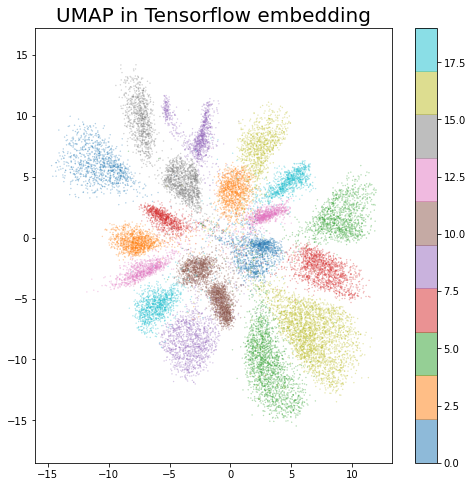

In [16]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### Save output

In [17]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [18]:
output_dir = MODEL_DIR/'projections'/ dataset / algorithm
ensure_dir(output_dir)

In [19]:
#vae.save(output_dir)

In [22]:
model.save_model(output_dir / 'iris.ivis')

In [23]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [24]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [25]:
X_test.shape

(1000, 32, 32)

In [26]:
z_test = model.transform(x_scaler.transform(X_test_flat).reshape([len(X_test)]+ list(dims)))

8/8 [==============================] - 0s 8ms/step


#### silhouette

In [27]:
from tfumap.silhouette import silhouette_score_block

In [28]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.4011048155845312

In [29]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.48096684694436664

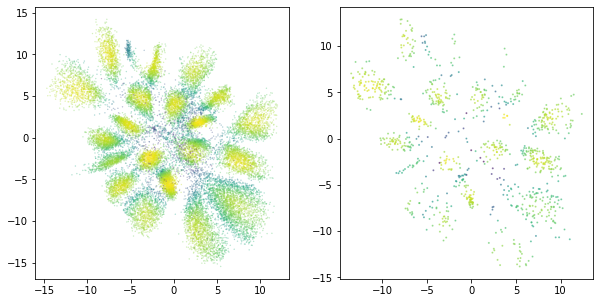

In [30]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.976

In [33]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.957

#### Trustworthiness

In [34]:
from sklearn.manifold import trustworthiness

In [35]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [36]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [37]:
tw, tw_test

(0.955960050040032, 0.9754467741935484)

### Save output metrics

In [38]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [39]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, algorithm, n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,cassins,ivis,2,0.95596,0.401105,"[0.4202558213008866, 0.5744271766978267, 0.325..."


In [40]:
save_loc = DATA_DIR / 'projection_metrics' /  algorithm / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [41]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, algorithm, n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,cassins,ivis,2,0.975447,0.480967,"[0.28178093013833866, 0.6001048007875612, 0.43..."


In [42]:
save_loc = DATA_DIR / 'projection_metrics' / algorithm / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [43]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = [algorithm, n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,ivis,2,cassins,0.957,0.976


In [44]:
save_loc = DATA_DIR / 'knn_classifier' / algorithm / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [46]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                np.array(y).flatten(), np.array(clustered_y).flatten()
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [47]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, algorithm, z, Y_train, n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,cassins,ivis,"[[-4.19835, 3.6293087], [-2.1161742, -3.038073...","[14, 11, 11, 11, 11, 11, 11, 11, 11, 17, 0, 0,...",2


In [48]:
??get_cluster_metrics

In [49]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/ivis_2_cassins.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,cassins,ivis,2,0.430770,0.667436,0.866434,0.754026,0,10,"KMeans(n_clusters=10, random_state=0)"
1,cassins,ivis,2,0.430666,0.667465,0.866545,0.754087,1,10,"KMeans(n_clusters=10, random_state=1)"
2,cassins,ivis,2,0.430785,0.667390,0.866403,0.753985,2,10,"KMeans(n_clusters=10, random_state=2)"
3,cassins,ivis,2,0.430787,0.667456,0.866490,0.754060,3,10,"KMeans(n_clusters=10, random_state=3)"
4,cassins,ivis,2,0.430775,0.667426,0.866459,0.754030,4,10,"KMeans(n_clusters=10, random_state=4)"
...,...,...,...,...,...,...,...,...,...,...
95,cassins,ivis,2,0.436651,0.870880,0.770449,0.817592,0,29,"KMeans(n_clusters=29, random_state=0)"
96,cassins,ivis,2,0.434841,0.874989,0.773965,0.821382,1,29,"KMeans(n_clusters=29, random_state=1)"
97,cassins,ivis,2,0.450863,0.886471,0.782981,0.831518,2,29,"KMeans(n_clusters=29, random_state=2)"
98,cassins,ivis,2,0.443735,0.883926,0.785362,0.831734,3,29,"KMeans(n_clusters=29, random_state=3)"
